In [2]:
pip install seaborn

     -------------------------------------- 294.8/294.8 kB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 10.6/10.6 MB 5.8 MB/s eta 0:00:00
     ---------------------------------------- 7.6/7.6 MB 5.7 MB/s eta 0:00:00
     ------------------------------------ 187.6/187.6 kB 943.2 kB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 5.3 MB/s eta 0:00:00
     ---------------------------------------- 56.1/56.1 kB 2.9 MB/s eta 0:00:00
  Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)
  Using cached pytz-2023.3.post1-py2.py3-none-any.whl (502 kB)
     -------------------------------------- 346.6/346.6 kB 5.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Code adapted from Gavin, H.P. (2020) The Levenberg-Marquardt method for 
# nonlinear least squares curve-fitting problems.
# https://people.duke.edu/~hpgavin/ce281/lm.pdf

import numpy as np
import seaborn as sns
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

def lm_func(t,p):
    """

    Define model function used for nonlinear least squares curve-fitting.

    Parameters
    ----------
    t     : independent variable values (assumed to be error-free) (m x 1)
    p     : parameter values , n = 4 in these examples             (n x 1)

    Returns
    -------
    y_hat : curve-fit fctn evaluated at points t and with parameters p (m x 1)

    """
    
    y_hat = p[0,0]*np.exp(-t/p[1,0]) + p[2,0]*np.sin(t/p[3,0])
    
    return y_hat


def lm_FD_J(t,p,y,dp):
    """

    Computes partial derivates (Jacobian) dy/dp via finite differences.

    Parameters
    ----------
    t  :     independent variables used as arg to lm_func (m x 1) 
    p  :     current parameter values (n x 1)
    y  :     func(t,p,c) initialised by user before each call to lm_FD_J (m x 1)
    dp :     fractional increment of p for numerical derivatives
                - dp(j)>0 central differences calculated
                - dp(j)<0 one sided differences calculated
                - dp(j)=0 sets corresponding partials to zero; i.e. holds p(j) fixed

    Returns
    -------
    J :      Jacobian Matrix (n x m)

    """

    global func_calls
    
    # number of data points
    m = len(y)
    # number of parameters
    n = len(p)

    # initialize Jacobian to Zero
    ps=p
    J=np.zeros((m,n)) 
    del_=np.zeros((n,1))
    
    # START --- loop over all parameters
    for j in range(n):
        # parameter perturbation
        del_[j,0] = dp[j,0] * (1+abs(p[j,0]))
        # perturb parameter p(j)
        p[j,0]   = ps[j,0] + del_[j,0]
        
        if del_[j,0] != 0:
            y1 = lm_func(t,p)
            func_calls = func_calls + 1
            
            if dp[j,0] < 0: 
                # backwards difference
                J[:,j] = (y1-y)/del_[j,0]
            else:
                # central difference, additional func call
                p[j,0] = ps[j,0] - del_[j]
                J[:,j] = (y1-lm_func(t,p)) / (2 * del_[j,0])
                func_calls = func_calls + 1
        
        # restore p(j)
        p[j,0]=ps[j,0]
        
    return J
    

def lm_Broyden_J(p_old,y_old,J,p,y):
    """
    Carry out a rank-1 update to the Jacobian matrix using Broyden's equation.

    Parameters
    ----------
    p_old :     previous set of parameters (n x 1)
    y_old :     model evaluation at previous set of parameters, y_hat(t,p_old) (m x 1)
    J     :     current version of the Jacobian matrix (m x n)
    p     :     current set of parameters (n x 1)
    y     :     model evaluation at current  set of parameters, y_hat(t,p) (m x 1)

    Returns
    -------
    J     :     rank-1 update to Jacobian Matrix J(i,j)=dy(i)/dp(j) (m x n)

    """
    
    h = p - p_old
    
    a = (np.array([y - y_old]).T - J@h)@h.T
    b = h.T@h

    # Broyden rank-1 update eq'n
    J = J + a/b

    return J

def lm_matx(t,p_old,y_old,dX2,J,p,y_dat,weight,dp):
    """
    Evaluate the linearized fitting matrix, JtWJ, and vector JtWdy, and 
    calculate the Chi-squared error function, Chi_sq used by Levenberg-Marquardt 
    algorithm (lm).
    
    Parameters
    ----------
    t      :     independent variables used as arg to lm_func (m x 1)
    p_old  :     previous parameter values (n x 1)
    y_old  :     previous model ... y_old = y_hat(t,p_old) (m x 1)
    dX2    :     previous change in Chi-squared criteria (1 x 1)
    J      :     Jacobian of model, y_hat, with respect to parameters, p (m x n)
    p      :     current parameter values (n x 1)
    y_dat  :     data to be fit by func(t,p,c) (m x 1)
    weight :     the weighting vector for least squares fit inverse of 
                 the squared standard measurement errors
    dp     :     fractional increment of 'p' for numerical derivatives
                  - dp(j)>0 central differences calculated
                  - dp(j)<0 one sided differences calculated
                  - dp(j)=0 sets corresponding partials to zero; i.e. holds p(j) fixed

    Returns
    -------
    JtWJ   :     linearized Hessian matrix (inverse of covariance matrix) (n x n)
    JtWdy  :     linearized fitting vector (n x m)
    Chi_sq :     Chi-squared criteria: weighted sum of the squared residuals WSSR
    y_hat  :     model evaluated with parameters 'p' (m x 1)
    J :          Jacobian of model, y_hat, with respect to parameters, p (m x n)

    """
    
    global iteration,func_calls
    
    # number of parameters
    Npar   = len(p)

    # evaluate model using parameters 'p'
    y_hat = lm_func(t,p)
    
    func_calls = func_calls + 1

    if not np.remainder(iteration,2*Npar) or dX2 > 0:
        # finite difference
        J = lm_FD_J(t,p,y_hat,dp)
    else:
        # rank-1 update
        J = lm_Broyden_J(p_old,y_old,J,p,y_hat)

    # residual error between model and data
    delta_y = np.array([y_dat - y_hat]).T
    
    # Chi-squared error criteria
    Chi_sq = delta_y.T @ ( delta_y * weight )  

    JtWJ  = J.T @ ( J * ( weight * np.ones((1,Npar)) ) )
    
    JtWdy = J.T @ ( weight * delta_y )
    
    
    return JtWJ,JtWdy,Chi_sq,y_hat,J


def lm(p,t,y_dat):  
    """
    
    Levenberg Marquardt curve-fitting: minimize sum of weighted squared residuals

    Parameters
    ----------
    p : initial guess of parameter values (n x 1)
    t : independent variables (used as arg to lm_func) (m x 1)
    y_dat : data to be fit by func(t,p) (m x 1)

    Returns
    -------
    p       : least-squares optimal estimate of the parameter values
    redX2   : reduced Chi squared error criteria - should be close to 1
    sigma_p : asymptotic standard error of the parameters
    sigma_y : asymptotic standard error of the curve-fit
    corr_p  : correlation matrix of the parameters
    R_sq    : R-squared cofficient of multiple determination  
    cvg_hst : convergence history (col 1: function calls, col 2: reduced chi-sq,
              col 3 through n: parameter values). Row number corresponds to
              iteration number.

    """

    global iteration, func_calls
    
    # iteration counter
    iteration  = 0
    # running count of function evaluations
    func_calls = 0
    
    # define eps (not available in python)
    eps = 2**(-52)

    # number of parameters
    Npar   = len(p)
    # number of data points
    Npnt   = len(y_dat)
    # previous set of parameters
    p_old  = np.zeros((Npar,1))
    # previous model, y_old = y_hat(t,p_old)
    y_old  = np.zeros((Npnt,1))
    # a really big initial Chi-sq value
    X2     = 1e-3/eps
    # a really big initial Chi-sq value
    X2_old = 1e-3/eps
    # Jacobian matrix
    J      = np.zeros((Npnt,Npar))
    # statistical degrees of freedom
    DoF    = np.array([[Npnt - Npar + 1]])
    
    
    if len(t) != len(y_dat):
        print('The length of t must equal the length of y_dat!')
        X2 = 0 
        corr_p = 0 
        sigma_p = 0 
        sigma_y = 0
        R_sq = 0

    # weights or a scalar weight value ( weight >= 0 )
    weight = 1/(y_dat.T@y_dat)
    # fractional increment of 'p' for numerical derivatives
    dp = [-0.001]      
    # lower bounds for parameter values
    p_min = -100*abs(p)  
    # upper bounds for parameter values       
    p_max = 100*abs(p)

    MaxIter       = 1000        # maximum number of iterations
    epsilon_1     = 1e-3        # convergence tolerance for gradient
    epsilon_2     = 1e-3        # convergence tolerance for parameters
    epsilon_4     = 1e-1        # determines acceptance of a L-M step
    lambda_0      = 1e-2        # initial value of damping paramter, lambda
    lambda_UP_fac = 11          # factor for increasing lambda
    lambda_DN_fac = 9           # factor for decreasing lambda
    Update_Type   = 1           # 1: Levenberg-Marquardt lambda update, 2: Quadratic update, 3: Nielsen's lambda update equations 

    if len(dp) == 1:
        dp = dp*np.ones((Npar,1))

    idx   = np.arange(len(dp))  # indices of the parameters to be fit
    stop = 0                    # termination flag

    # identical weights vector
    if np.var(weight) == 0:         
        weight = abs(weight)*np.ones((Npnt,1))        
        print('Using uniform weights for error analysis')
    else:
        weight = abs(weight)

    # initialize Jacobian with finite difference calculation
    JtWJ,JtWdy,X2,y_hat,J = lm_matx(t,p_old,y_old,1,J,p,y_dat,weight,dp)
    if np.abs(JtWdy).max() < epsilon_1:
        print('*** Your Initial Guess is Extremely Close to Optimal ***')
    
    lambda_0 = np.atleast_2d([lambda_0])

    # Marquardt: init'l lambda
    if Update_Type == 1:
        lambda_  = lambda_0
    # Quadratic and Nielsen
    else:
        lambda_  = lambda_0 * max(np.diag(JtWJ))
        nu=2
    
    # previous value of X2 
    X2_old = X2
    # initialize convergence history
    cvg_hst = np.ones((MaxIter,Npar+2))   
    
    # -------- Start Main Loop ----------- #
    while not stop and iteration <= MaxIter:
        
        iteration = iteration + 1
 
        # incremental change in parameters
        # Marquardt
        if Update_Type == 1:
            h = np.linalg.solve((JtWJ + lambda_*np.diag(np.diag(JtWJ)) ), JtWdy)  
        # Quadratic and Nielsen
        else:
            h = np.linalg.solve(( JtWJ + lambda_*np.eye(Npar) ), JtWdy)

        # update the [idx] elements
        p_try = p + h[idx]
        # apply constraints                             
        p_try = np.minimum(np.maximum(p_min,p_try),p_max)       
    
        # residual error using p_try
        delta_y = np.array([y_dat - lm_func(t,p_try)]).T
        
        # floating point error; break       
        if not all(np.isfinite(delta_y)):                   
          stop = 1
          break     

        func_calls = func_calls + 1
        # Chi-squared error criteria
        X2_try = delta_y.T @ ( delta_y * weight )
        
        # % Quadratic
        if Update_Type == 2:                        
          # One step of quadratic line update in the h direction for minimum X2
          alpha =  np.divide(JtWdy.T @ h, ( (X2_try - X2)/2 + 2*JtWdy.T@h ))
          h = alpha * h
          
          # % update only [idx] elements
          p_try = p + h[idx]
          # % apply constraints
          p_try = np.minimum(np.maximum(p_min,p_try),p_max)         
          
          # % residual error using p_try
          delta_y = y_dat - lm_func(t,p_try)     
          func_calls = func_calls + 1
          # % Chi-squared error criteria
          X2_try = delta_y.T @ ( delta_y * weight )   
  
        rho = np.matmul( h.T @ (lambda_ * h + JtWdy),np.linalg.inv(X2 - X2_try))
    
        # it IS significantly better
        if ( rho > epsilon_4 ):                         
    
            dX2 = X2 - X2_old
            X2_old = X2
            p_old = p
            y_old = y_hat
            # % accept p_try
            p = p_try                        
        
            JtWJ,JtWdy,X2,y_hat,J = lm_matx(t,p_old,y_old,dX2,J,p,y_dat,weight,dp)
            
            # % decrease lambda ==> Gauss-Newton method
            # % Levenberg
            if Update_Type == 1:
                lambda_ = max(lambda_/lambda_DN_fac,1.e-7)
            # % Quadratic
            elif Update_Type == 2:
                lambda_ = max( lambda_/(1 + alpha) , 1.e-7 )
            # % Nielsen
            else:
                lambda_ = lambda_*max( 1/3, 1-(2*rho-1)**3 )
                nu = 2
            
        # it IS NOT better
        else:                                           
            # % do not accept p_try
            X2 = X2_old
    
            if not np.remainder(iteration,2*Npar):            
                JtWJ,JtWdy,dX2,y_hat,J = lm_matx(t,p_old,y_old,-1,J,p,y_dat,weight,dp)
    
            # % increase lambda  ==> gradient descent method
            # % Levenberg
            if Update_Type == 1:
                lambda_ = min(lambda_*lambda_UP_fac,1.e7)
            # % Quadratic
            elif Update_Type == 2:
                lambda_ = lambda_ + abs((X2_try - X2)/2/alpha)
            # % Nielsen
            else:
                lambda_ = lambda_ * nu
                nu = 2*nu

        # update convergence history ... save _reduced_ Chi-square
        cvg_hst[iteration-1,0] = func_calls
        cvg_hst[iteration-1,1] = X2/DoF
        
        for i in range(Npar):
            cvg_hst[iteration-1,i+2] = p.T[0][i]

        if ( max(abs(JtWdy)) < epsilon_1  and  iteration > 2 ):
          print('**** Convergence in r.h.s. ("JtWdy")  ****')
          stop = 1
    
        if ( max(abs(h)/(abs(p)+1e-12)) < epsilon_2  and  iteration > 2 ): 
          print('**** Convergence in Parameters ****')
          stop = 1
    
        if ( iteration == MaxIter ):
          print('!! Maximum Number of Iterations Reached Without Convergence !!')
          stop = 1

        # --- End of Main Loop --- #
        # --- convergence achieved, find covariance and confidence intervals

    #  ---- Error Analysis ----
    #  recompute equal weights for paramter error analysis
    if np.var(weight) == 0:   
        weight = DoF/(delta_y.T@delta_y) * np.ones((Npnt,1))
      
    # % reduced Chi-square                            
    redX2 = X2 / DoF

    JtWJ,JtWdy,X2,y_hat,J = lm_matx(t,p_old,y_old,-1,J,p,y_dat,weight,dp)

    # standard error of parameters 
    covar_p = np.linalg.inv(JtWJ)
    sigma_p = np.sqrt(np.diag(covar_p)) 
    error_p = sigma_p/p
    
    # standard error of the fit
    sigma_y = np.zeros((Npnt,1))
    for i in range(Npnt):
        sigma_y[i,0] = J[i,:] @ covar_p @ J[i,:].T        

    sigma_y = np.sqrt(sigma_y)

    # parameter correlation matrix
    corr_p = covar_p / [sigma_p@sigma_p.T]
        
    # coefficient of multiple determination
    R_sq = np.correlate(y_dat, y_hat)
    R_sq = 0        

    # convergence history
    cvg_hst = cvg_hst[:iteration,:]
    
    print('\nLM fitting results:')
    for i in range(Npar):
        print('----------------------------- ')
        print('parameter      = p%i' %(i+1))
        print('fitted value   = %0.4f' % p[i,0])
        print('standard error = %0.2f %%' % error_p[i,0])
    
    return p,redX2,sigma_p,sigma_y,corr_p,R_sq,cvg_hst

def make_lm_plots(x,y,cvg_hst):
    

    # extract parameters data
    p_hst  = cvg_hst[:,2:]
    p_fit  = p_hst[-1,:]
    y_fit = lm_func(x,np.array([p_fit]).T)
    
    # define fonts used for plotting
    font_axes = {'family': 'serif',
            'weight': 'normal',
            'size': 12}
    font_title = {'family': 'serif',
                  'weight': 'normal',
            'size': 14}       
    
    # define colors and markers used for plotting
    n = len(p_fit)
    colors = pl.cm.ocean(np.linspace(0,.75,n))
    markers = ['o','s','D','v']    
    
    # create plot of raw data and fitted curve
    fig1, ax1 = plt.subplots()
    ax1.plot(x,y,'wo',markeredgecolor='black',label='Raw data')
    ax1.plot(x,y_fit,'r--',label='Fitted curve',linewidth=2)
    ax1.set_xlabel('t',fontdict=font_axes)
    ax1.set_ylabel('y(t)',fontdict=font_axes)
    ax1.set_title('Data fitting',fontdict=font_title)
    ax1.legend()
    
    # create plot showing convergence of parameters
    fig2, ax2 = plt.subplots()
    for i in range(n):
        ax2.plot(cvg_hst[:,0],p_hst[:,i]/p_hst[0,i],color=colors[i],marker=markers[i],
                 linestyle='-',markeredgecolor='black',label='p'+'${_%i}$'%(i+1))
    ax2.set_xlabel('Function calls',fontdict=font_axes)
    ax2.set_ylabel('Values (norm.)',fontdict=font_axes)
    ax2.set_title('Convergence of parameters',fontdict=font_title) 
    ax2.legend()
    
    # create plot showing histogram of residuals
    fig3, ax3 = plt.subplots()
    sns.histplot(ax=ax3,data=y_fit-y,color='deepskyblue')
    ax3.set_xlabel('Residual error',fontdict=font_axes)
    ax3.set_ylabel('Frequency',fontdict=font_axes)
    ax3.set_title('Histogram of residuals',fontdict=font_title)
    
    # create plot showing objective function surface plot
    fig4, ax4 = plt.subplots(subplot_kw={"projection": "3d"})
    # define range of values for gridded parameter search
    p2 = np.arange(0.1*p_fit[1], 2.5*p_fit[1], 0.1)
    p4 = np.arange(0.1*p_fit[3], 2.5*p_fit[3], 0.1)
    X2 = np.zeros((len(p4),len(p2)))
    # gridded parameter search
    for i in range(len(p2)):
        for j in range(len(p4)):
            pt = np.array([[p_hst[-1,0],p2[i],p_hst[-1,2],p4[j]]]).T
            delta_y = y - lm_func(x,pt)
            X2[j,i] = np.log((delta_y.T @ delta_y)/(len(x)-len(p_fit)))    
    p2_grid, p4_grid = np.meshgrid(p2, p4)
    # make surface plot
    ax4.plot_surface(p2_grid, p4_grid, X2, cmap='coolwarm', antialiased=True)
    ax4.set_xlabel('P$_2$',fontdict=font_axes)
    ax4.set_ylabel('P$_4$',fontdict=font_axes)
    ax4.set_zlabel('log$_{10}$($\chi$$^2$)',fontdict=font_axes,rotation=90)
    ax4.set_title('Objective Function',fontdict=font_title)
    ax4.zaxis.set_rotate_label(False)
    ax4.azim = 225

Using uniform weights for error analysis
**** Convergence in Parameters ****

LM fitting results:
----------------------------- 
parameter      = p1
fitted value   = 6.0566
standard error = 3.16 %
----------------------------- 
parameter      = p2
fitted value   = 22.8455
standard error = 0.84 %
----------------------------- 
parameter      = p3
fitted value   = 0.9887
standard error = 19.37 %
----------------------------- 
parameter      = p4
fitted value   = 4.9638
standard error = 3.86 %


C:\Users\DELL\AppData\Local\Temp\ipykernel_1468\3043938275.py:388: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cvg_hst[iteration-1,1] = X2/DoF


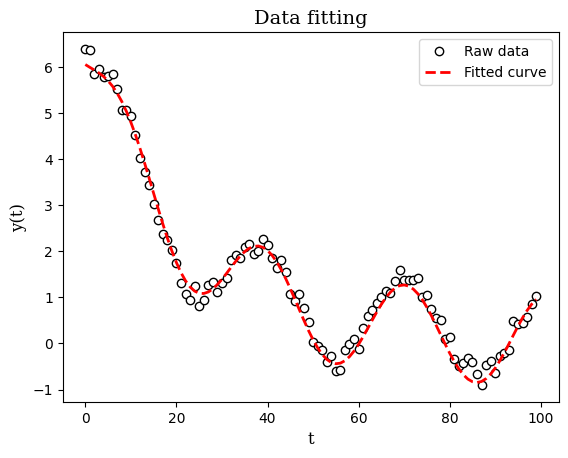

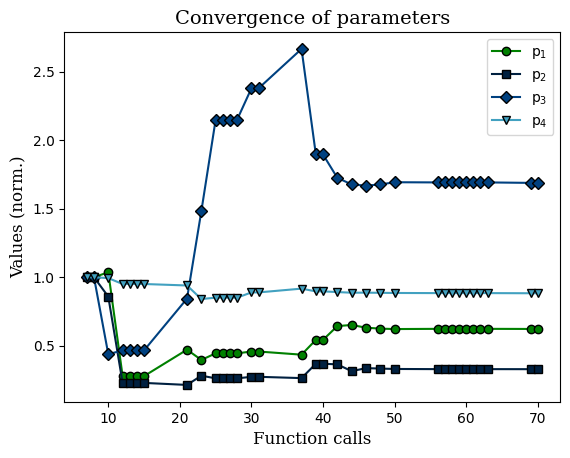

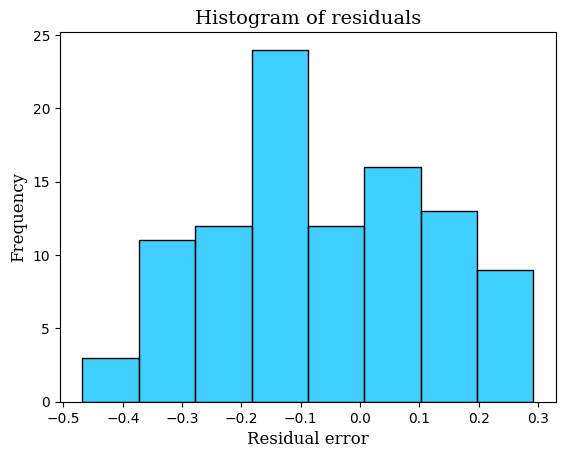

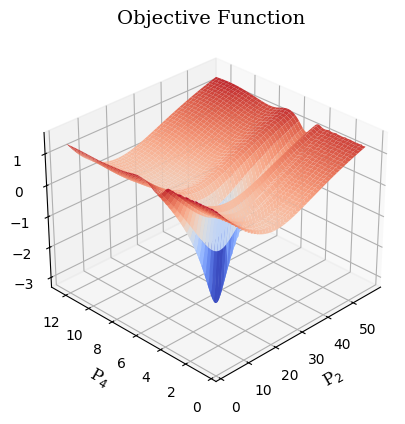

In [3]:
# Code adapted from Gavin, H.P. (2020) The Levenberg-Marquardt method for 
# nonlinear least squares curve-fitting problems.
# https://people.duke.edu/~hpgavin/ce281/lm.pdf
    
import numpy as np
import matplotlib.pyplot as plt

def make_noisy_test_data(p_true,Npnt,msmnt_err):
    """
    
    Make noisy test data.

    Parameters
    ----------
    p_true      : true fitted parameters values (n x 1), must be 2D array
    Npnt        : number of data points (m = Npnt)
    msmnt_err   : amount of noise added to model data

    Returns
    -------
    x           : x-values of test data (m x 1), must be 2D array
    y           : y-values of test data (m x 1), must be 2D array

    """
    
    x = np.array(range(Npnt)).T
    y_true = lm_func(x,p_true)
    
    # add random measurement errors
    rng = np.random.default_rng()
    y = y_true + msmnt_err*rng.random((Npnt)) 
    
    return x,y

def main(x,y,p_init):
    """
    
    Main function for performing Levenberg-Marquardt curve fitting.

    Parameters
    ----------
    x           : x-values of input data (m x 1), must be 2D array
    y           : y-values of input data (m x 1), must be 2D array
    p_init      : initial guess of parameters values (n x 1), must be 2D array
                  n = 4 in this example

    Returns
    -------
    p       : least-squares optimal estimate of the parameter values
    Chi_sq  : reduced Chi squared error criteria - should be close to 1
    sigma_p : asymptotic standard error of the parameters
    sigma_y : asymptotic standard error of the curve-fit
    corr    : correlation matrix of the parameters
    R_sq    : R-squared cofficient of multiple determination  
    cvg_hst : convergence history (col 1: function calls, col 2: reduced chi-sq,
              col 3 through n: parameter values). Row number corresponds to
              iteration number.

    """
    
    # close all plots
    plt.close('all')
    
    # minimize sum of weighted squared residuals with L-M least squares analysis
    p_fit,Chi_sq,sigma_p,sigma_y,corr,R_sq,cvg_hst = lm(p_init,x,y)
    
    # plot results of L-M least squares analysis
    make_lm_plots(x, y, cvg_hst)
    
    return p_fit,Chi_sq,sigma_p,sigma_y,corr,R_sq,cvg_hst
    
if __name__ == '__main__':
    
    # flag for making noisy test data
    make_test_data = True
    
    # make test data with noise
    if make_test_data:
        # define true fitted parameters for testing (must be 2D array)
        p_true = np.array([[6,20,1,5]]).T
        # define initial guess of parameters (must be 2D array)
        p_init = np.array([[10,50,5,5.7]]).T
        # number of data points (x-values will range from 0 to 99)
        Npnt = 100 
        # adding noise to input data to simulate artificial measurements
        msmnt_err = 0.5 
        
        x,y = make_noisy_test_data(p_true,Npnt,msmnt_err)
        
    p_fit,Chi_sq,sigma_p,sigma_y,corr,R_sq,cvg_hst = main(x,y,p_init)

In [5]:
# define true fitted parameters for testing (must be 2D array)
p_true = np.array([[6,20,1,5]]).T
# define initial guess of parameters (must be 2D array)
p_init = np.array([[10,50,5,5.7]]).T
# number of data points (x-values will range from 0 to 99)
Npnt = 100 
# adding noise to input data to simulate artificial measurements
msmnt_err = 0.5 

x,y = make_noisy_test_data(p_true,Npnt,msmnt_err)

In [6]:
p,t,y_dat = p_init, x, y

In [7]:
global iteration, func_calls

# iteration counter
iteration  = 0
# running count of function evaluations
func_calls = 0

# define eps (not available in python)
eps = 2**(-52)

# number of parameters
Npar   = len(p)
# number of data points
Npnt   = len(y_dat)
# previous set of parameters
p_old  = np.zeros((Npar,1))
# previous model, y_old = y_hat(t,p_old)
y_old  = np.zeros((Npnt,1))
# a really big initial Chi-sq value
X2     = 1e-3/eps
# a really big initial Chi-sq value
X2_old = 1e-3/eps
# Jacobian matrix
J      = np.zeros((Npnt,Npar))
# statistical degrees of freedom
DoF    = np.array([[Npnt - Npar + 1]])

In [8]:
# weights or a scalar weight value ( weight >= 0 )
weight = 1/(y_dat.T@y_dat)

In [9]:
weight

0.0018039153058839418

In [10]:
# fractional increment of 'p' for numerical derivatives
dp = [-0.001]      
# lower bounds for parameter values
p_min = -100*abs(p)  
# upper bounds for parameter values       
p_max = 100*abs(p)

In [11]:
p_max

array([[1000.],
       [5000.],
       [ 500.],
       [ 570.]])

In [12]:
MaxIter       = 1000        # maximum number of iterations
epsilon_1     = 1e-3        # convergence tolerance for gradient
epsilon_2     = 1e-3        # convergence tolerance for parameters
epsilon_4     = 1e-1        # determines acceptance of a L-M step
lambda_0      = 1e-2        # initial value of damping paramter, lambda
lambda_UP_fac = 11          # factor for increasing lambda
lambda_DN_fac = 9           # factor for decreasing lambda
Update_Type   = 1           # 1: Levenberg-Marquardt lambda update, 2: Quadratic update, 3: Nielsen's lambda update equations

In [13]:
if len(dp) == 1:
    dp = dp*np.ones((Npar,1))

idx   = np.arange(len(dp))  # indices of the parameters to be fit
stop = 0                    # termination flag

# identical weights vector
if np.var(weight) == 0:         
    weight = abs(weight)*np.ones((Npnt,1))        
    print('Using uniform weights for error analysis')
else:
    weight = abs(weight)

Using uniform weights for error analysis


In [14]:
dp

array([[-0.001],
       [-0.001],
       [-0.001],
       [-0.001]])

In [15]:
np.remainder(0,2*4)

0

In [19]:
lambda_0 = np.atleast_2d([lambda_0])

In [20]:
lambda_0

array([[[0.01]]])

In [18]:
lambda_0.shape

(1, 1)

In [22]:
import numpy as np

matrix = np.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])

diagonal_elements = np.diag(np.diag(matrix))
print(diagonal_elements)

[[1 0 0]
 [0 5 0]
 [0 0 9]]
